# ADL(0–6) 回归 + 有序分类 一键Notebook

在下方设置 `DATA_PATH` 与（可选）`TARGET_HINT`，然后从上到下运行即可。

In [1]:
DATA_PATH = "./wave3ndata.csv"  # 例如 'data/wave3ndata.csv'
TARGET_HINT = "adlab_c"  # 若你的目标列名不同，可填入正确名字；也可留空让脚本自动识别


In [2]:

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, accuracy_score,
                             confusion_matrix)
from sklearn.metrics import cohen_kappa_score


In [3]:

def detect_target_column(df, hint=None):
    if hint and hint in df.columns: return hint
    candidates = ["adlab-c","adl","adlab","adl_c","adl_score","ADL","ADL_score"]
    for c in df.columns:
        if c.strip().lower() in [x.lower() for x in candidates]:
            return c
    for c in df.columns[::-1]:
        if pd.api.types.is_numeric_dtype(df[c]):
            vals = pd.unique(df[c].dropna())
            if set(np.unique(vals)).issubset(set(range(0,7))):
                return c
    for c in df.columns:
        if "adl" in c.lower() and pd.api.types.is_numeric_dtype(df[c]):
            return c
    raise ValueError("未能识别 ADL 目标列，请将列名包含 'adl' 且为 0..6 整数")


In [4]:

df = pd.read_csv(DATA_PATH)
target_col = detect_target_column(df, hint=TARGET_HINT if TARGET_HINT else None)
y = df[target_col].astype(int).values
X = df.drop(columns=[target_col])
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
X = X[num_cols].copy()

bin_cols, con_cols = [], []
for c in num_cols:
    vals = pd.unique(X[c].dropna())
    if set(np.unique(vals)).issubset({0,1}):
        bin_cols.append(c)
    else:
        con_cols.append(c)
for c in bin_cols:
    if X[c].isna().any():
        X[c] = X[c].fillna(X[c].mode().iloc[0])
for c in con_cols:
    if X[c].isna().any():
        X[c] = X[c].fillna(X[c].median())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train/Test:", X_train.shape, X_test.shape, "Target:", target_col)


Train/Test: (5204, 63) (1302, 63) Target: adlab_c


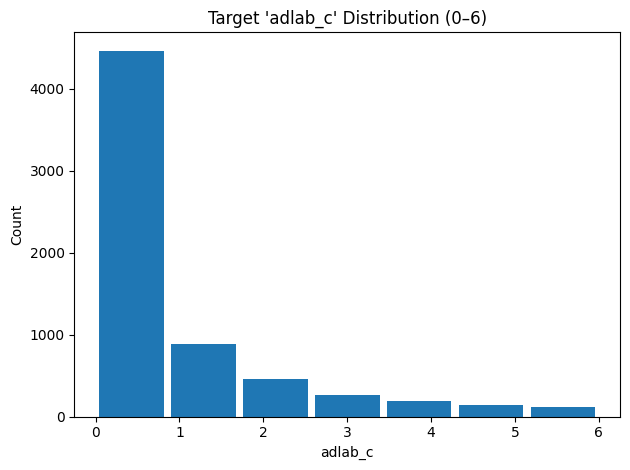

In [5]:

# 目标分布
plt.figure()
pd.Series(y).plot(kind="hist", bins=7, rwidth=0.9)
plt.title(f"Target '{target_col}' Distribution (0–6)")
plt.xlabel(target_col); plt.ylabel("Count")
plt.tight_layout()


In [6]:

def reg_report(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    y_round = np.clip(np.rint(y_pred), 0, 6).astype(int)
    acc = accuracy_score(y_true, y_round)
    within1 = np.mean(np.abs(y_true - y_round) <= 1)
    return dict(MAE=mae, RMSE=rmse, R2=r2, Acc_rounded=acc, Within1=within1)


In [7]:

# 回归：ElasticNet（带标准化）
preproc = ColumnTransformer([("scale", StandardScaler(), X.columns.tolist())], remainder="drop")
enet = Pipeline([
    ("prep", preproc),
    ("model", ElasticNetCV(l1_ratio=[0.1,0.5,0.9], alphas=np.logspace(-2,1,15), cv=3, random_state=42, max_iter=5000))
])
enet.fit(X_train, y_train)
pred_enet = enet.predict(X_test)
report_enet = reg_report(y_test, pred_enet)
report_enet


c:\Users\11466\Anaconda\envs\Yarn_prodiction\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': 0.5974260018121857,
 'RMSE': 0.9225989639137494,
 'R2': 0.5493302162248033,
 'Acc_rounded': 0.6105990783410138,
 'Within1': 0.8832565284178188}

In [8]:

# 回归：HistGradientBoosting
hgb_reg = HistGradientBoostingRegressor(learning_rate=0.05, max_leaf_nodes=31, min_samples_leaf=20, random_state=42)
hgb_reg.fit(X_train, y_train)
pred_hgb = hgb_reg.predict(X_test)
report_hgb = reg_report(y_test, pred_hgb)
report_hgb


c:\Users\11466\Anaconda\envs\Yarn_prodiction\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': 0.5755583554442748,
 'RMSE': 0.9020973959150392,
 'R2': 0.5691368284614929,
 'Acc_rounded': 0.6382488479262672,
 'Within1': 0.9001536098310292}

In [9]:

# 有序分类：K-1 个二分类器学习 y>k
K = 7
ord_clfs = []
for k in range(K-1):
    y_bin = (y_train > k).astype(int)
    clf = HistGradientBoostingClassifier(learning_rate=0.06, max_leaf_nodes=31, min_samples_leaf=20, random_state=42)
    clf.fit(X_train, y_bin)
    ord_clfs.append(clf)

def ordinal_predict_proba(X_new):
    import numpy as np
    ps = []
    for k, clf in enumerate(ord_clfs):
        p = clf.predict_proba(X_new)[:, 1]
        ps.append(p)
    ps = np.vstack(ps)
    n = X_new.shape[0]
    P = np.zeros((n, K))
    P[:, 0] = 1 - ps[0]
    for c in range(1, K-1):
        P[:, c] = ps[c-1] - ps[c]
    P[:, K-1] = ps[-1]
    P = np.clip(P, 1e-9, 1.0)
    P /= P.sum(axis=1, keepdims=True)
    return P

P = ordinal_predict_proba(X_test)
y_pred_ord = P.argmax(axis=1)
acc = (y_pred_ord == y_test).mean()
mae_cls = np.mean(np.abs(y_pred_ord - y_test))
within1 = np.mean(np.abs(y_pred_ord - y_test) <= 1)
qwk = cohen_kappa_score(y_test, y_pred_ord, weights="quadratic")
{"Acc": acc, "MAE_on_classes": mae_cls, "Within1": within1, "QWK": qwk}


{'Acc': 0.6881720430107527,
 'MAE_on_classes': 0.5092165898617511,
 'Within1': 0.8748079877112135,
 'QWK': 0.6806476964577772}

In [ ]:

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred_ord)
plt.figure()
im = plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Ordinal Classification)")
plt.colorbar(im)
ticks = np.arange(7)
plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()



## PSO-LSSVM（RBF 核）
本节在 Notebook 中加入 **PSO（粒子群优化）** + **LSSVM（最小二乘支持向量机）** 的回归模型：  
- 核函数：RBF  
- 需调参：正则化系数 `gamma`、核宽 `sigma`  
- 用 **PSO** 在训练集内的验证集上最小化 MAE，得到最优 `(gamma, sigma)` 后，用全训练集拟合，在测试集评估。

> 说明：LSSVM 的闭式解可以通过构造核矩阵并求解线性方程组得到；对中等规模数据（几千样本内）较合适。大规模数据可酌情降采样或使用近似核。


In [10]:

import numpy as np
from numpy.linalg import solve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

# -- RBF kernel
def rbf_kernel(X1, X2, sigma):
    # sigma > 0
    if sigma <= 0:
        raise ValueError("sigma must be > 0")
    # ||x - z||^2 = (x^2).sum + (z^2).sum - 2 x z^T
    X1_sq = np.sum(X1**2, axis=1)[:, None]
    X2_sq = np.sum(X2**2, axis=1)[None, :]
    dist2 = X1_sq + X2_sq - 2.0 * X1 @ X2.T
    K = np.exp(-dist2 / (2.0 * sigma * sigma))
    return K

# -- LSSVM fit (regression)
def lssvm_fit_rbf(X_tr, y_tr, gamma, sigma, jitter=1e-8):
    n = X_tr.shape[0]
    one = np.ones((n, 1))
    K = rbf_kernel(X_tr, X_tr, sigma)
    # Solve [ 0   1^T ] [ b     ] = [ 0 ]
    #       [ 1  K+I/g ] [ alpha ]   [ y ]
    A = np.zeros((n+1, n+1), dtype=float)
    A[0, 1:] = 1.0
    A[1:, 0] = 1.0
    A[1:, 1:] = K + (1.0/gamma) * np.eye(n) + jitter*np.eye(n)
    rhs = np.zeros((n+1, 1), dtype=float)
    rhs[1:, 0] = y_tr.ravel()
    sol = solve(A, rhs)  # [b; alpha]
    b = sol[0, 0]
    alpha = sol[1:, 0]
    return {"X_tr": X_tr.copy(), "alpha": alpha, "b": b, "sigma": sigma}

def lssvm_predict(model, X_te):
    K = rbf_kernel(X_te, model["X_tr"], model["sigma"])
    yhat = K @ model["alpha"] + model["b"]
    return yhat.ravel()

# -- Evaluate helper
def eval_report_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    y_round = np.clip(np.rint(y_pred), 0, 6).astype(int)
    acc = accuracy_score(y_true, y_round)
    within1 = np.mean(np.abs(y_true - y_round) <= 1)
    return dict(MAE=mae, RMSE=rmse, R2=r2, Acc_rounded=acc, Within1=within1)

# -- PSO (simple)
def pso_optimize(objective, bounds, n_particles=12, iters=25, w=0.72, c1=1.49, c2=1.49, seed=42):
    rng = np.random.default_rng(seed)
    dim = len(bounds)
    # init
    Xp = np.zeros((n_particles, dim))
    Vp = np.zeros((n_particles, dim))
    for d, (lo, hi) in enumerate(bounds):
        Xp[:, d] = rng.uniform(lo, hi, size=n_particles)
        Vp[:, d] = 0.1 * (hi - lo) * rng.uniform(-1, 1, size=n_particles)
    fp = np.array([objective(x) for x in Xp])
    Pp = Xp.copy()          # personal best positions
    Fp = fp.copy()          # personal best scores
    g_idx = int(np.argmin(fp))
    G = Xp[g_idx].copy()    # global best position
    Fg = fp[g_idx]          # global best score

    for _ in range(iters):
        r1 = rng.random((n_particles, dim))
        r2 = rng.random((n_particles, dim))
        Vp = w*Vp + c1*r1*(Pp - Xp) + c2*r2*(G - Xp)
        Xp = Xp + Vp
        # clamp
        for d, (lo, hi) in enumerate(bounds):
            Xp[:, d] = np.clip(Xp[:, d], lo, hi)
        fp = np.array([objective(x) for x in Xp])
        # update personal best
        better = fp < Fp
        Pp[better] = Xp[better]
        Fp[better] = fp[better]
        # update global best
        g_idx = int(np.argmin(Fp))
        G = Pp[g_idx].copy()
        Fg = Fp[g_idx]
    return G, Fg


In [11]:

# === PSO-LSSVM: 数据标准化 + 内层验证 ===
# 使用与前文相同的 X_train, y_train, X_test, y_test 变量
assert 'X_train' in globals(), "请先运行前文的数据准备单元格（Train/Test split）。"
from sklearn.model_selection import train_test_split

# 1) 标准化（LSSVM对尺度敏感）
scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train)
Xs_test  = scaler.transform(X_test)

# 2) 在训练集划一个小验证集用于PSO寻参
X_tr, X_val, y_tr, y_val = train_test_split(Xs_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# 3) 定义目标函数：给定 (log10(gamma), log10(sigma)) 返回验证MAE
def obj_fn(theta):
    lg_gamma, lg_sigma = theta
    gamma = 10.0**lg_gamma
    sigma = 10.0**lg_sigma
    try:
        model = lssvm_fit_rbf(X_tr, y_tr, gamma=gamma, sigma=sigma)
        pred = lssvm_predict(model, X_val)
        return mean_absolute_error(y_val, pred)
    except Exception as e:
        return 1e9  # 数值失败时返回大值

# 4) PSO 搜索区间（对数空间）
bounds = [(-2.0, 3.0),  # log10(gamma) in [1e-2, 1e3]
          (-2.0, 2.0)]  # log10(sigma) in [1e-2, 1e2]

best_theta, best_score = pso_optimize(obj_fn, bounds, n_particles=14, iters=30, seed=123)
best_gamma = 10.0**best_theta[0]
best_sigma = 10.0**best_theta[1]

print("Best (gamma, sigma):", best_gamma, best_sigma, " | Val MAE:", best_score)

# 5) 用最优超参在整个训练集（标准化后）重训，并在测试集评估
model_lssvm = lssvm_fit_rbf(Xs_train, y_train, gamma=best_gamma, sigma=best_sigma)
pred_test = lssvm_predict(model_lssvm, Xs_test)
report_lssvm = eval_report_regression(y_test, pred_test)
report_lssvm


Best (gamma, sigma): 1000.0 82.28428713950136  | Val MAE: 0.6168833001889172


c:\Users\11466\Anaconda\envs\Yarn_prodiction\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': 0.596693924946454,
 'RMSE': 0.9124325047099641,
 'R2': 0.5592076870175094,
 'Acc_rounded': 0.6136712749615976,
 'Within1': 0.8863287250384024}